In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, ReLU, Bidirectional,BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] =False
plt.rcParams.update({"font.size":20})
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, recall_score

In [14]:
negative = pd.read_csv('data/Negative.txt', header = None, index_col=None) 
negative = negative.drop_duplicates()
negative['label'] = 0
positive = pd.read_csv('data/Positive.txt', header = None, index_col=None) 
positive = positive.drop_duplicates()
positive['label'] = 1
# negative[negative.isnull().values==True] # 判断是否存在缺失值

In [15]:
data = pd.concat([negative, positive], axis=0).reset_index().iloc[:, 1:]
data = data.dropna()

In [16]:
# 数据归一化处理
x_data = data.iloc[:, :-1]
y_data = data.loc[:, 'label']
mm = MinMaxScaler([-1, 1])
x_data_mm = mm.fit_transform(x_data)
# 数据降维
# pca = PCA(n_components=10) 
# x_data_mm_pca = pca.fit_transform(x_data_mm)
# 类别均衡化
model_smote = SMOTE()  
x_resampled, y_resampled = model_smote.fit_resample(x_data_mm,y_data)

In [17]:
# 划分训练数据为80%训练集和20%的验证集
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=7, shuffle=True)

In [18]:
# 重置数据维度
x_train = x_train.reshape(-1,1,x_train.shape[-1])
x_test = x_test.reshape(-1,1,x_test.shape[-1])

In [19]:
# 对类别数据进行onehot编码
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [20]:
# 构建网络
model = Sequential() 
model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='relu', input_dim=x_train.shape[-1], input_length=x_train.shape[1])))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=64)))
model.add(BatchNormalization())
model.add(Dense(2, activation = 'softmax'))

In [25]:
# 训练网络
epochs = 200 # 训练周期
batch_size = 64 # 批次大小 
# 监视网络的训练，并将在验证集上取得最优结果的网络权重保留下来
checkpoint = ModelCheckpoint("BiLSTM_V7_9.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max') 
# 监视网络的训练，并对学习率进行衰减处理
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1)
callbacks_list = [checkpoint, reduce_lr] # 监视列表 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # 编译网络
# 开始训练，直接使用30%的验证集，在训练过程中测试网络
history = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=epochs, batch_size=batch_size, verbose=1,validation_data=(x_test, y_test))

Epoch 1/200
24/28 [========================>.....] - ETA: 0s - loss: 0.0206 - accuracy: 0.9948
Epoch 00001: val_accuracy improved from -inf to 0.84270, saving model to BiLSTM_V7_9.h5
28/28 [==============================] - 1s 46ms/step - loss: 0.0191 - accuracy: 0.9949 - val_loss: 1.5455 - val_accuracy: 0.8427 - lr: 0.0010
Epoch 2/200
24/28 [========================>.....] - ETA: 0s - loss: 0.0079 - accuracy: 0.9974
Epoch 00002: val_accuracy did not improve from 0.84270
28/28 [==============================] - 0s 8ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 4.4643 - val_accuracy: 0.5640 - lr: 0.0010
Epoch 3/200
22/28 [======================>.......] - ETA: 0s - loss: 0.0051 - accuracy: 0.9986
Epoch 00003: val_accuracy did not improve from 0.84270
28/28 [==============================] - 0s 9ms/step - loss: 0.0096 - accuracy: 0.9972 - val_loss: 1.8049 - val_accuracy: 0.6629 - lr: 0.0010
Epoch 4/200
26/28 [==========================>...] - ETA: 0s - loss: 0.0182 - accuracy: 0.

Epoch 29/200
25/28 [=========================>....] - ETA: 0s - loss: 0.0052 - accuracy: 0.9981
Epoch 00029: val_accuracy did not improve from 0.84270
28/28 [==============================] - 0s 8ms/step - loss: 0.0052 - accuracy: 0.9983 - val_loss: 0.9770 - val_accuracy: 0.8112 - lr: 5.0000e-04
Epoch 30/200
24/28 [========================>.....] - ETA: 0s - loss: 5.2575e-04 - accuracy: 1.0000
Epoch 00030: val_accuracy improved from 0.84270 to 0.87865, saving model to BiLSTM_V7_9.h5
28/28 [==============================] - 0s 10ms/step - loss: 5.6932e-04 - accuracy: 1.0000 - val_loss: 0.6696 - val_accuracy: 0.8787 - lr: 5.0000e-04
Epoch 31/200
25/28 [=========================>....] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000    
Epoch 00031: val_accuracy did not improve from 0.87865
28/28 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.7437 - val_accuracy: 0.8449 - lr: 5.0000e-04
Epoch 32/200
25/28 [=========================>....] - ETA: 0

Epoch 56/200
22/28 [======================>.......] - ETA: 0s - loss: 0.0068 - accuracy: 0.9979
Epoch 00056: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 9ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 1.4786 - val_accuracy: 0.7438 - lr: 5.0000e-04
Epoch 57/200
28/28 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9932
Epoch 00057: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 9ms/step - loss: 0.0168 - accuracy: 0.9932 - val_loss: 1.7497 - val_accuracy: 0.8090 - lr: 5.0000e-04
Epoch 58/200
22/28 [======================>.......] - ETA: 0s - loss: 0.0183 - accuracy: 0.9964
Epoch 00058: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 9ms/step - loss: 0.0181 - accuracy: 0.9961 - val_loss: 6.0268 - val_accuracy: 0.6112 - lr: 5.0000e-04
Epoch 59/200
26/28 [==========================>...] - ETA: 0s - loss: 0.0305 - accuracy: 0.9892
Epoch 00059: 

22/28 [======================>.......] - ETA: 0s - loss: 4.8104e-04 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 9ms/step - loss: 4.5773e-04 - accuracy: 1.0000 - val_loss: 0.7606 - val_accuracy: 0.8966 - lr: 2.5000e-04
Epoch 84/200
23/28 [=======================>......] - ETA: 0s - loss: 3.8307e-04 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 8ms/step - loss: 3.5530e-04 - accuracy: 1.0000 - val_loss: 0.7930 - val_accuracy: 0.9011 - lr: 2.5000e-04
Epoch 85/200
24/28 [========================>.....] - ETA: 0s - loss: 2.5952e-04 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 8ms/step - loss: 2.7059e-04 - accuracy: 1.0000 - val_loss: 0.8316 - val_accuracy: 0.8989 - lr: 2.5000e-04
Epoch 86/200
23/28 [=======================>......] - ETA: 0s - loss: 4.3707e-04 - accuracy: 1.000

Epoch 110/200
23/28 [=======================>......] - ETA: 0s - loss: 0.0020 - accuracy: 0.9993
Epoch 00110: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 1.1889 - val_accuracy: 0.8831 - lr: 6.2500e-05
Epoch 111/200
26/28 [==========================>...] - ETA: 0s - loss: 5.3503e-04 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 10ms/step - loss: 5.0334e-04 - accuracy: 1.0000 - val_loss: 1.1365 - val_accuracy: 0.8921 - lr: 6.2500e-05
Epoch 112/200
22/28 [======================>.......] - ETA: 0s - loss: 4.9918e-04 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 9ms/step - loss: 4.1982e-04 - accuracy: 1.0000 - val_loss: 1.0344 - val_accuracy: 0.8899 - lr: 6.2500e-05
Epoch 113/200
22/28 [======================>.......] - ETA: 0s - loss: 7.0607e-04 - accur

Epoch 137/200
22/28 [======================>.......] - ETA: 0s - loss: 3.0076e-04 - accuracy: 1.0000
Epoch 00137: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 10ms/step - loss: 2.7573e-04 - accuracy: 1.0000 - val_loss: 0.9055 - val_accuracy: 0.9079 - lr: 3.1250e-05
Epoch 138/200
22/28 [======================>.......] - ETA: 0s - loss: 5.2860e-04 - accuracy: 1.0000
Epoch 00138: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 9ms/step - loss: 5.2713e-04 - accuracy: 1.0000 - val_loss: 0.9172 - val_accuracy: 0.9056 - lr: 3.1250e-05
Epoch 139/200
22/28 [======================>.......] - ETA: 0s - loss: 1.7545e-04 - accuracy: 1.0000
Epoch 00139: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 9ms/step - loss: 2.0081e-04 - accuracy: 1.0000 - val_loss: 0.9163 - val_accuracy: 0.9056 - lr: 3.1250e-05
Epoch 140/200
27/28 [===========================>..] - ETA: 0s - loss: 4.1392e-04

Epoch 164/200
24/28 [========================>.....] - ETA: 0s - loss: 3.1336e-04 - accuracy: 1.0000
Epoch 00164: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 12ms/step - loss: 3.3557e-04 - accuracy: 1.0000 - val_loss: 0.9061 - val_accuracy: 0.9056 - lr: 1.5625e-05
Epoch 165/200
28/28 [==============================] - ETA: 0s - loss: 4.6951e-04 - accuracy: 1.0000
Epoch 00165: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 13ms/step - loss: 4.6951e-04 - accuracy: 1.0000 - val_loss: 0.9026 - val_accuracy: 0.9056 - lr: 1.5625e-05
Epoch 166/200
23/28 [=======================>......] - ETA: 0s - loss: 2.2152e-04 - accuracy: 1.0000
Epoch 00166: val_accuracy did not improve from 0.92584

Epoch 00166: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
28/28 [==============================] - 0s 14ms/step - loss: 2.0353e-04 - accuracy: 1.0000 - val_loss: 0.9024 - val_accuracy: 0.9034 - lr: 1.5625e-0

27/28 [===========================>..] - ETA: 0s - loss: 1.3556e-04 - accuracy: 1.0000
Epoch 00190: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 13ms/step - loss: 1.3283e-04 - accuracy: 1.0000 - val_loss: 0.9233 - val_accuracy: 0.9011 - lr: 3.9063e-06
Epoch 191/200
27/28 [===========================>..] - ETA: 0s - loss: 1.7592e-04 - accuracy: 1.0000
Epoch 00191: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 13ms/step - loss: 0.0013 - accuracy: 0.9994 - val_loss: 0.9212 - val_accuracy: 0.9011 - lr: 3.9063e-06
Epoch 192/200
26/28 [==========================>...] - ETA: 0s - loss: 2.4792e-04 - accuracy: 1.0000
Epoch 00192: val_accuracy did not improve from 0.92584
28/28 [==============================] - 0s 13ms/step - loss: 2.3877e-04 - accuracy: 1.0000 - val_loss: 0.9378 - val_accuracy: 0.9034 - lr: 3.9063e-06
Epoch 193/200
27/28 [===========================>..] - ETA: 0s - loss: 4.6065e-04 - accuracy: 1.0

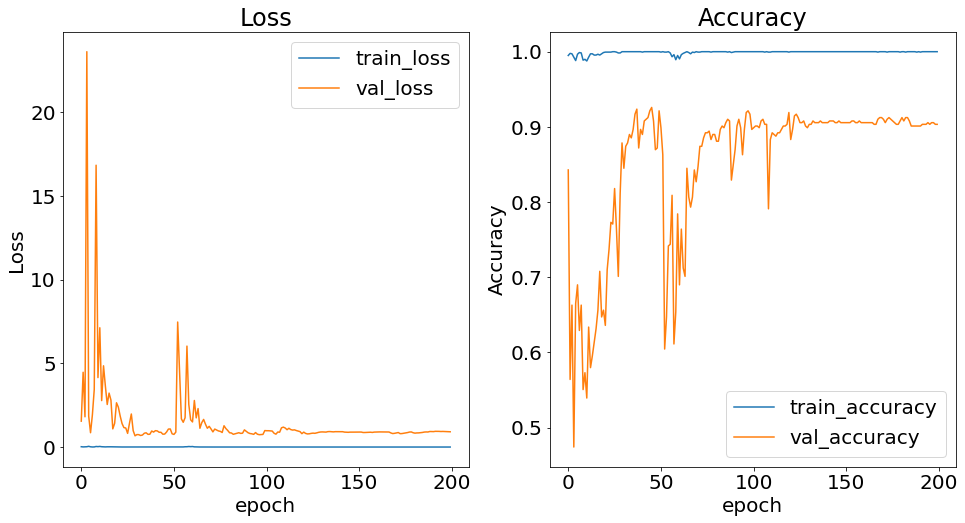

In [26]:
# 可视化训练过程中，训练集与验证集的损失和精度
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [27]:
# 使用模型得到预测结果
model = load_model('BiLSTM_V7_9.h5')
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [28]:
print('在80%训练集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1)), recall_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary'), f1_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary')))
print('在20%测试集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1)), recall_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary'), f1_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary')))

在80%训练集上, accuracy: 1.0% 召回率:  1.0, f1:  1.0
在20%测试集上, accuracy: 0.9258% 召回率: 0.9623430962343096, f1: 0.9330628803245435


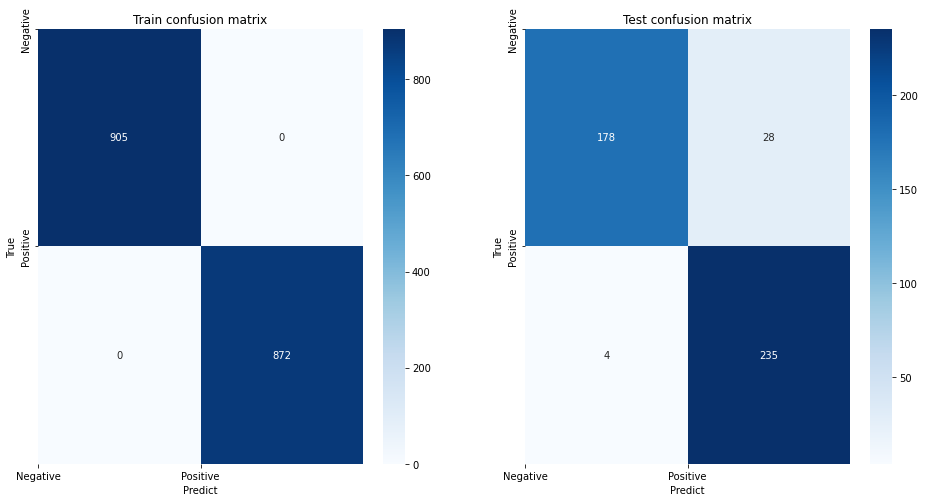

In [66]:
# 绘制混淆矩阵
plt.figure(figsize=(16,8))
plt.subplot(121)
matrix = confusion_matrix(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Train confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.subplot(122)
matrix = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Test confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.show()